In [1]:
import os
import time
import shutil
from rdkit import Chem
from rdkit.Chem import AllChem
from typing import Tuple, Dict


ensemble_comp="ensemble_comp_m74_dft"
if os.path.exists(ensemble_comp):
    shutil.rmtree(ensemble_comp)
os.makedirs(ensemble_comp, exist_ok= True)
os.chdir(ensemble_comp)

####input parameter
inp_path="/Users/sourav/Desktop/pka_calc/conformer_comparison/pka_esti_compare_dft_opt_conf_3methods_5mols//m74"


In [2]:
!obabel {inp_path}/rest2/cluster_rep_conformers_dft_opt.sdf -m -O MD_conf_.sdf 
!obabel {inp_path}/gnnis/cluster_rep_conformers_dft_opt.sdf -m -O gnnis_conf_.sdf 
!obabel {inp_path}/molconsul/cluster_rep_conformers_dft_opt.sdf -m -O rdkit_conf_.sdf 

4 molecules converted
4 files output. The first is MD_conf_1.sdf
5 molecules converted
5 files output. The first is gnnis_conf_1.sdf
5 molecules converted
5 files output. The first is rdkit_conf_1.sdf


In [3]:
%%time
import subprocess
import glob

# Method names
a = "REMD"
b = "RDKit-ETKDG"
c = "GNNIS"

# Get conformer files for each method
a_confs = sorted(glob.glob("MD_conf_*.sdf"))
b_confs = sorted(glob.glob("rdkit_conf_*.sdf"))
c_confs = sorted(glob.glob("gnnis_conf_*.sdf"))

def calculate_rmsd_matrix(confs1, confs2, output_file, method1_name, method2_name):
    """Calculate RMSD matrix between two sets of conformers"""
    with open(output_file, "w") as fout:
        # Write header
        fout.write("," + ",".join([f"{method2_name}_{i+1}" for i in range(len(confs2))]) + "\n")
        
        # Calculate RMSD for each pair
        for i, conf1 in enumerate(confs1):
            row = [f"{method1_name}_{i+1}"]
            for conf2 in confs2:
                result = subprocess.run(
                    ["obrms", "-m", conf1, conf2],
                    capture_output=True, text=True
                )
                try:
                    rmsd = float(result.stdout.strip().split()[-1])
                except:
                    rmsd = "NaN"
                row.append(str(rmsd))
            fout.write(",".join(row) + "\n")
    print(f"Generated {output_file}")

# Generate all three pairwise comparison matrices
print("Generating RMSD matrices...")

# A vs B (REMD vs RDKit-ETKDG)
calculate_rmsd_matrix(a_confs, b_confs, "A_vs_B_rmsd_matrix.csv", a, b)

# A vs C (REMD vs GNNIS)  
calculate_rmsd_matrix(a_confs, c_confs, "A_vs_C_rmsd_matrix.csv", a, c)

# B vs C (RDKit-ETKDG vs GNNIS)
calculate_rmsd_matrix(b_confs, c_confs, "B_vs_C_rmsd_matrix.csv", b, c)

print("All RMSD matrices generated successfully!")
print(f"Files created:")
print(f"- A_vs_B_rmsd_matrix.csv ({a} vs {b})")
print(f"- A_vs_C_rmsd_matrix.csv ({a} vs {c})")  
print(f"- B_vs_C_rmsd_matrix.csv ({b} vs {c})")

Generating RMSD matrices...
Generated A_vs_B_rmsd_matrix.csv
Generated A_vs_C_rmsd_matrix.csv
Generated B_vs_C_rmsd_matrix.csv
All RMSD matrices generated successfully!
Files created:
- A_vs_B_rmsd_matrix.csv (REMD vs RDKit-ETKDG)
- A_vs_C_rmsd_matrix.csv (REMD vs GNNIS)
- B_vs_C_rmsd_matrix.csv (RDKit-ETKDG vs GNNIS)
CPU times: user 18.4 ms, sys: 108 ms, total: 127 ms
Wall time: 9.38 s


Generating RMSD heatmaps...
Saved RMSD_heatmap_REMD_vs_RDKit.png and RMSD_heatmap_REMD_vs_RDKit.pdf


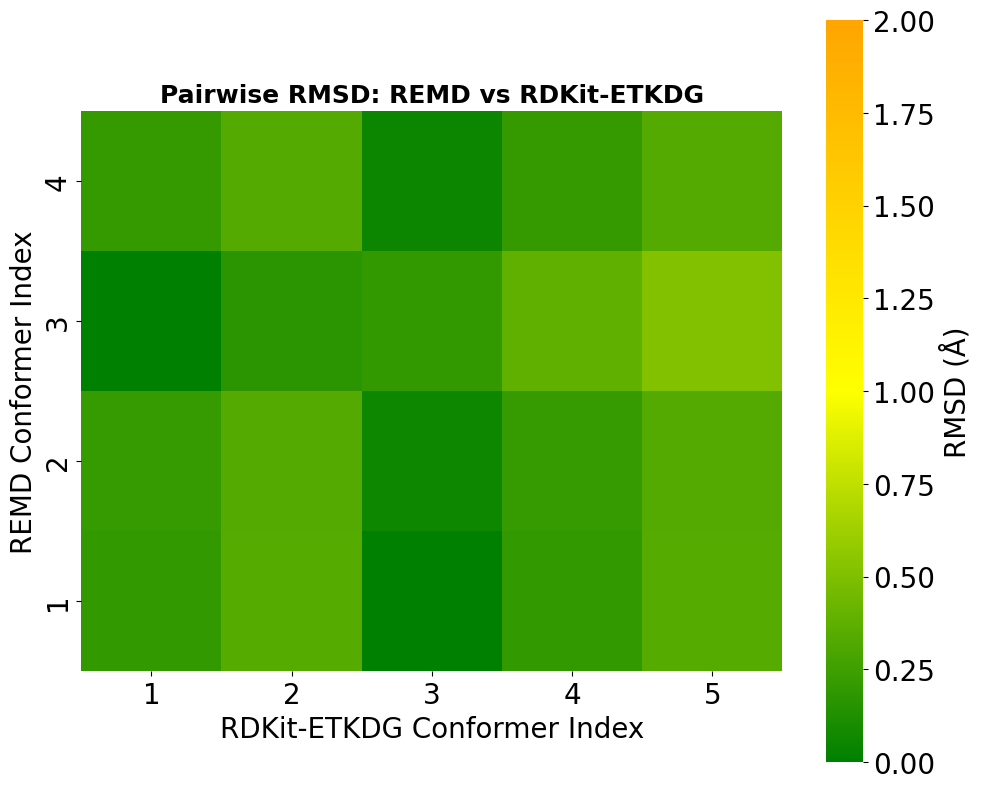

Saved RMSD_heatmap_REMD_vs_GNNIS.png and RMSD_heatmap_REMD_vs_GNNIS.pdf


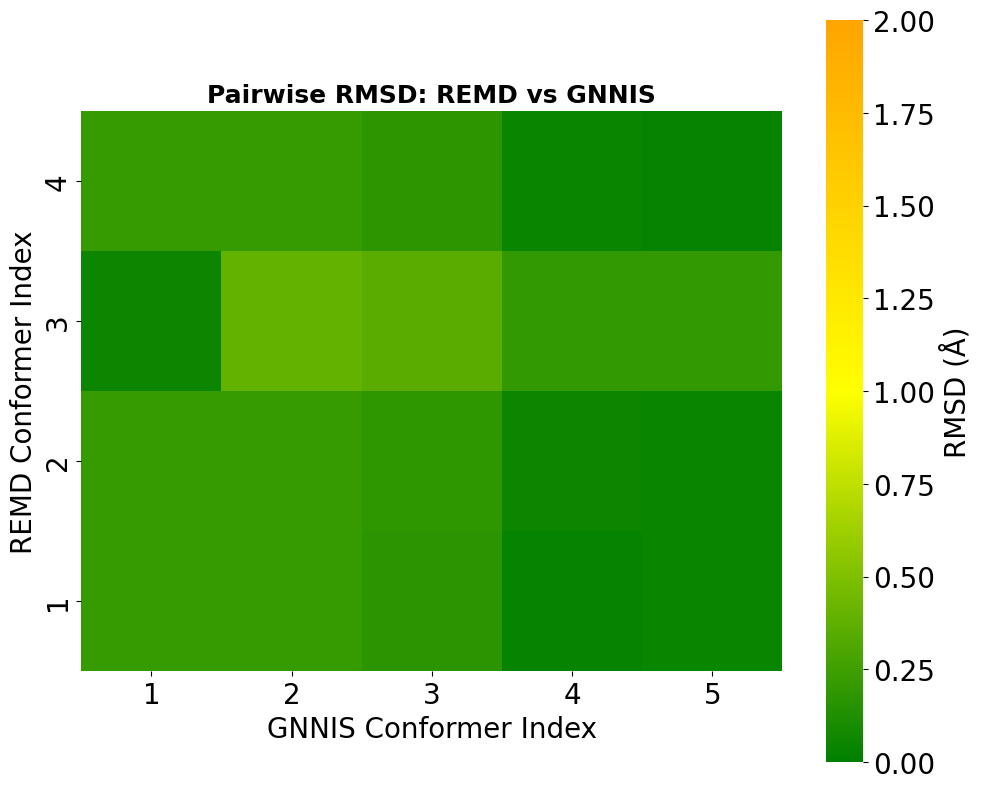

Saved RMSD_heatmap_RDKit_vs_GNNIS.png and RMSD_heatmap_RDKit_vs_GNNIS.pdf


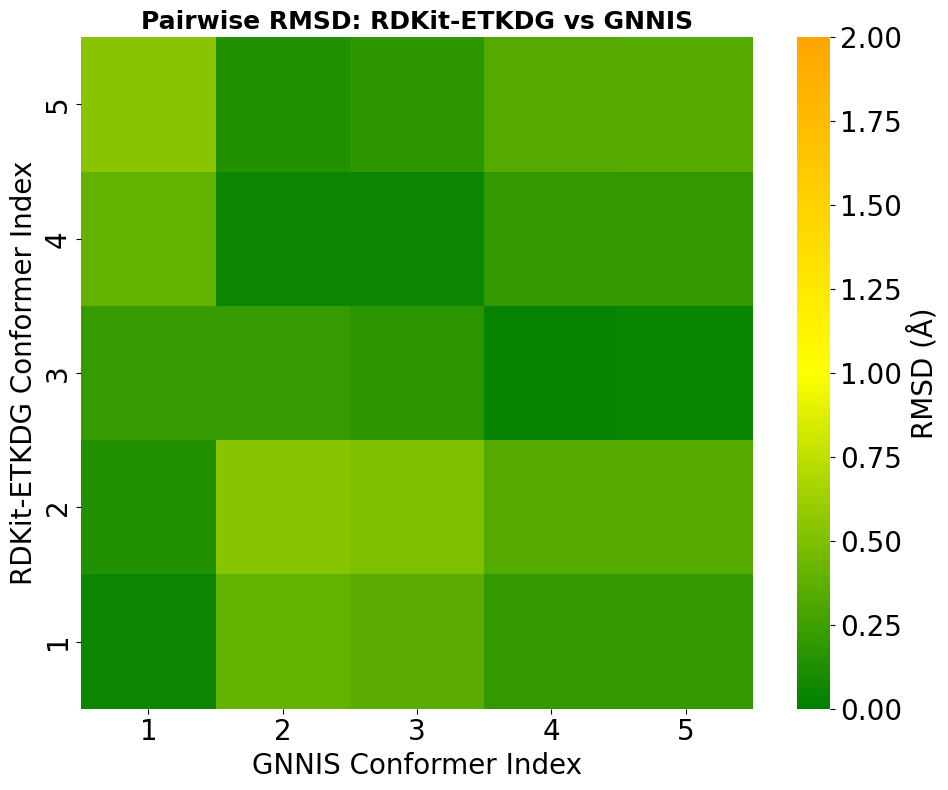


All heatmaps generated successfully!
Files saved:
- RMSD_heatmap_REMD_vs_RDKit.png/pdf
- RMSD_heatmap_REMD_vs_GNNIS.png/pdf
- RMSD_heatmap_RDKit_vs_GNNIS.png/pdf

Summary Statistics:
REMD vs RDKit-ETKDG: RMSD range 0.00 - 0.51 Å
REMD vs GNNIS: RMSD range 0.03 - 0.40 Å
RDKit-ETKDG vs GNNIS: RMSD range 0.03 - 0.53 Å


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Method names
a = "REMD"
b = "RDKit-ETKDG"
c = "GNNIS"

# File mappings
csv_files = [
    ("A_vs_B_rmsd_matrix.csv", a, b),
    ("A_vs_C_rmsd_matrix.csv", a, c),
    ("B_vs_C_rmsd_matrix.csv", b, c)
]

def plot_rmsd_heatmap(csv_file, method1, method2, save_name):
    """Create and save RMSD heatmap with values displayed in cells"""
    
    # Load the data
    df = pd.read_csv(csv_file, index_col=0)
    
    # Convert to float, replacing any non-numeric values with NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Reset index and column names to integers starting from 1
    df.index = np.arange(1, len(df.index) + 1)
    df.columns = np.arange(1, len(df.columns) + 1)
    
    # Set fixed RMSD scale
    rmsd_min = 0.0
    rmsd_max = 2.0
    rmsd_mid = 1.0
    
    # Create custom colormap
    colors = ['green', 'yellow', 'orange']
    cmap = LinearSegmentedColormap.from_list("rmsd_cmap", colors, N=256)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot heatmap without annotations
    ax = sns.heatmap(
        df,
        cmap=cmap,
        square=True,
        vmin=rmsd_min,
        vmax=rmsd_max,
        center=rmsd_mid,
        cbar_kws={'label': 'RMSD (Å)'},
        xticklabels=True,
        yticklabels=True,
        annot=False  # No annotations
    )

    # Increase colorbar tick font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('RMSD (Å)', fontsize=20)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)) + 0.5)
    ax.set_xticklabels(df.columns, fontsize=20)
    ax.set_yticks(np.arange(len(df.index)) + 0.5)
    ax.set_yticklabels(df.index, fontsize=20)
    
    # Invert Y axis so it starts from bottom
    plt.gca().invert_yaxis()
    
    # Labels and layout
    plt.title(f"Pairwise RMSD: {method1} vs {method2}", fontsize=18, fontweight='bold')
    plt.xlabel(f"{method2} Conformer Index", fontsize=20)
    plt.ylabel(f"{method1} Conformer Index", fontsize=20)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"{save_name}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_name}.pdf", bbox_inches='tight')
    print(f"Saved {save_name}.png and {save_name}.pdf")
    
    # Show the plot
    plt.show()
    
    return df

# Generate all three heatmaps
print("Generating RMSD heatmaps...")

# Plot 1: A vs B (REMD vs RDKit-ETKDG)
df_ab = plot_rmsd_heatmap("A_vs_B_rmsd_matrix.csv", a, b, "RMSD_heatmap_REMD_vs_RDKit")

# Plot 2: A vs C (REMD vs GNNIS)
df_ac = plot_rmsd_heatmap("A_vs_C_rmsd_matrix.csv", a, c, "RMSD_heatmap_REMD_vs_GNNIS")

# Plot 3: B vs C (RDKit-ETKDG vs GNNIS)
df_bc = plot_rmsd_heatmap("B_vs_C_rmsd_matrix.csv", b, c, "RMSD_heatmap_RDKit_vs_GNNIS")

print("\nAll heatmaps generated successfully!")
print("Files saved:")
print("- RMSD_heatmap_REMD_vs_RDKit.png/pdf")
print("- RMSD_heatmap_REMD_vs_GNNIS.png/pdf") 
print("- RMSD_heatmap_RDKit_vs_GNNIS.png/pdf")

# Print summary statistics
print("\nSummary Statistics:")
print(f"REMD vs RDKit-ETKDG: RMSD range {df_ab.min().min():.2f} - {df_ab.max().max():.2f} Å")
print(f"REMD vs GNNIS: RMSD range {df_ac.min().min():.2f} - {df_ac.max().max():.2f} Å")
print(f"RDKit-ETKDG vs GNNIS: RMSD range {df_bc.min().min():.2f} - {df_bc.max().max():.2f} Å")

In [5]:
import numpy as np
import pandas as pd

# Method names
a = "REMD"
b = "RDKit-ETKDG"
c = "GNNIS"

# File mappings
csv_files = [
    ("A_vs_B_rmsd_matrix.csv", a, b),
    ("A_vs_C_rmsd_matrix.csv", a, c),
    ("B_vs_C_rmsd_matrix.csv", b, c)
]

def analyze_rmsd_matrix(csv_file, method1, method2):
    """Analyze RMSD matrix and find best matches"""
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {method1} vs {method2}")
    print(f"{'='*60}")
    
    # Load the data
    df = pd.read_csv(csv_file, index_col=0)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Convert DataFrame to NumPy array
    rmsd_matrix = df.values.astype(float)
    
    # Minimum RMSD values
    min_rmsd_A_to_B = np.nanmin(rmsd_matrix, axis=1)  # shape (A,) - best match for each method1 conformer
    min_rmsd_B_to_A = np.nanmin(rmsd_matrix, axis=0)  # shape (B,) - best match for each method2 conformer
    
    # Indices where min occurs
    min_rmsd_A_to_B_indices = np.nanargmin(rmsd_matrix, axis=1)  # for each A[i], index of B[j]
    min_rmsd_B_to_A_indices = np.nanargmin(rmsd_matrix, axis=0)  # for each B[j], index of A[i]
    
    # Summary statistics
    print(f"Average min RMSD ({method1} → {method2}): {np.nanmean(min_rmsd_A_to_B):.3f} Å")
    print(f"Average min RMSD ({method2} → {method1}): {np.nanmean(min_rmsd_B_to_A):.3f} Å")
    print(f"Max min RMSD ({method1} → {method2}): {np.nanmax(min_rmsd_A_to_B):.3f} Å")
    print(f"Max min RMSD ({method2} → {method1}): {np.nanmax(min_rmsd_B_to_A):.3f} Å")
    print(f"Min min RMSD ({method1} → {method2}): {np.nanmin(min_rmsd_A_to_B):.3f} Å")
    print(f"Min min RMSD ({method2} → {method1}): {np.nanmin(min_rmsd_B_to_A):.3f} Å")
    
    # Overall matrix statistics
    print(f"\nOverall Matrix Statistics:")
    print(f"Overall min RMSD: {np.nanmin(rmsd_matrix):.3f} Å")
    print(f"Overall max RMSD: {np.nanmax(rmsd_matrix):.3f} Å")
    print(f"Overall mean RMSD: {np.nanmean(rmsd_matrix):.3f} Å")
    print(f"Overall std RMSD: {np.nanstd(rmsd_matrix):.3f} Å")
    
    # Best-matching pairs (Method1 → Method2)
    matches_A_to_B = list(zip(
        np.arange(len(min_rmsd_A_to_B)) + 1,        # A indices (1-based)
        min_rmsd_A_to_B_indices + 1,                # B indices (1-based)
        min_rmsd_A_to_B                             # RMSD values
    ))
    
    # Best-matching pairs (Method2 → Method1)
    matches_B_to_A = list(zip(
        np.arange(len(min_rmsd_B_to_A)) + 1,        # B indices (1-based)
        min_rmsd_B_to_A_indices + 1,                # A indices (1-based)
        min_rmsd_B_to_A                             # RMSD values
    ))
    
    print(f"\nBest matches ({method1} → {method2}):")
    print("Conformer | Best Match | RMSD (Å)")
    print("-" * 35)
    for i, (a_idx, b_idx, rmsd_val) in enumerate(matches_A_to_B):
        print(f"{method1}_{a_idx:2d}   | {method2}_{b_idx:2d}      | {rmsd_val:.3f}")
    
    print(f"\nBest matches ({method2} → {method1}):")
    print("Conformer | Best Match | RMSD (Å)")
    print("-" * 35)
    for i, (b_idx, a_idx, rmsd_val) in enumerate(matches_B_to_A):
        print(f"{method2}_{b_idx:2d}   | {method1}_{a_idx:2d}      | {rmsd_val:.3f}")
    
    # Mutual best matches (bidirectional)
    print(f"\nMutual best matches (bidirectional):")
    print("Method1 | Method2 | RMSD (Å)")
    print("-" * 30)
    mutual_matches = []
    for i, (a_idx, b_best, rmsd_ab) in enumerate(matches_A_to_B):
        # Check if the best match from B back to A is also A
        if min_rmsd_B_to_A_indices[b_best-1] + 1 == a_idx:
            mutual_matches.append((a_idx, b_best, rmsd_ab))
            print(f"{method1}_{a_idx:2d}  | {method2}_{b_best:2d}    | {rmsd_ab:.3f}")
    
    if not mutual_matches:
        print("No mutual best matches found")
    
    return {
        'matrix': rmsd_matrix,
        'min_A_to_B': min_rmsd_A_to_B,
        'min_B_to_A': min_rmsd_B_to_A,
        'matches_A_to_B': matches_A_to_B,
        'matches_B_to_A': matches_B_to_A,
        'mutual_matches': mutual_matches,
        'stats': {
            'avg_min_A_to_B': np.nanmean(min_rmsd_A_to_B),
            'avg_min_B_to_A': np.nanmean(min_rmsd_B_to_A),
            'overall_min': np.nanmin(rmsd_matrix),
            'overall_max': np.nanmax(rmsd_matrix),
            'overall_mean': np.nanmean(rmsd_matrix),
            'overall_std': np.nanstd(rmsd_matrix)
        }
    }

# Analyze all three comparisons
results = {}
for csv_file, method1, method2 in csv_files:
    key = f"{method1}_vs_{method2}"
    results[key] = analyze_rmsd_matrix(csv_file, method1, method2)

# Overall comparison summary
print(f"\n{'='*60}")
print("OVERALL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_names = [f"{a}_vs_{b}", f"{a}_vs_{c}", f"{b}_vs_{c}"]
method_pairs = [(a, b), (a, c), (b, c)]

print("Comparison           | Avg Min RMSD | Overall Min | Overall Max | Overall Mean")
print("-" * 80)
for i, (comp_name, (m1, m2)) in enumerate(zip(comparison_names, method_pairs)):
    stats = results[comp_name]['stats']
    avg_min = (stats['avg_min_A_to_B'] + stats['avg_min_B_to_A']) / 2
    print(f"{m1:8s} vs {m2:8s} | {avg_min:11.3f} | {stats['overall_min']:10.3f} | {stats['overall_max']:10.3f} | {stats['overall_mean']:11.3f}")

# Find most similar methods
min_avg_rmsd = float('inf')
most_similar_pair = None
for comp_name, (m1, m2) in zip(comparison_names, method_pairs):
    stats = results[comp_name]['stats']
    avg_min = (stats['avg_min_A_to_B'] + stats['avg_min_B_to_A']) / 2
    if avg_min < min_avg_rmsd:
        min_avg_rmsd = avg_min
        most_similar_pair = (m1, m2)

print(f"\nMost similar methods: {most_similar_pair[0]} and {most_similar_pair[1]} (avg min RMSD: {min_avg_rmsd:.3f} Å)")

# Count mutual matches for each comparison
print(f"\nMutual best matches count:")
for comp_name, (m1, m2) in zip(comparison_names, method_pairs):
    mutual_count = len(results[comp_name]['mutual_matches'])
    print(f"{m1} vs {m2}: {mutual_count} mutual best matches")


ANALYSIS: REMD vs RDKit-ETKDG
Average min RMSD (REMD → RDKit-ETKDG): 0.027 Å
Average min RMSD (RDKit-ETKDG → REMD): 0.139 Å
Max min RMSD (REMD → RDKit-ETKDG): 0.060 Å
Max min RMSD (RDKit-ETKDG → REMD): 0.332 Å
Min min RMSD (REMD → RDKit-ETKDG): 0.000 Å
Min min RMSD (RDKit-ETKDG → REMD): 0.000 Å

Overall Matrix Statistics:
Overall min RMSD: 0.000 Å
Overall max RMSD: 0.515 Å
Overall mean RMSD: 0.229 Å
Overall std RMSD: 0.131 Å

Best matches (REMD → RDKit-ETKDG):
Conformer | Best Match | RMSD (Å)
-----------------------------------
REMD_ 1   | RDKit-ETKDG_ 3      | 0.000
REMD_ 2   | RDKit-ETKDG_ 3      | 0.060
REMD_ 3   | RDKit-ETKDG_ 1      | 0.000
REMD_ 4   | RDKit-ETKDG_ 3      | 0.048

Best matches (RDKit-ETKDG → REMD):
Conformer | Best Match | RMSD (Å)
-----------------------------------
RDKit-ETKDG_ 1   | REMD_ 3      | 0.000
RDKit-ETKDG_ 2   | REMD_ 3      | 0.168
RDKit-ETKDG_ 3   | REMD_ 1      | 0.000
RDKit-ETKDG_ 4   | REMD_ 1      | 0.195
RDKit-ETKDG_ 5   | REMD_ 2      | 0.33

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from html2image import Html2Image
import numpy as np

# Method file mappings
method_files = {
    'REMD': 'MD_conf_',
    'RDKit': 'rdkit_conf_',
    'GNNIS': 'gnnis_conf_'
}

def show_overlap(method1, conf1_idx, method2, conf2_idx, save_image=False):
    """
    Show overlap between two conformers from different methods
    
    Parameters:
    method1: str - 'REMD', 'RDKit', or 'GNNIS'
    conf1_idx: int - conformer index for method1
    method2: str - 'REMD', 'RDKit', or 'GNNIS'  
    conf2_idx: int - conformer index for method2
    save_image: bool - whether to save as PNG
    """
    
    # Get file prefixes
    prefix1 = method_files[method1]
    prefix2 = method_files[method2]
    
    # Load molecules
    try:
        mol1 = Chem.MolFromMolFile(f'{prefix1}{conf1_idx}.sdf', removeHs=False)
        mol2 = Chem.MolFromMolFile(f'{prefix2}{conf2_idx}.sdf', removeHs=False)
        
        if mol1 is None or mol2 is None:
            print(f"Error: Could not load one or both molecules")
            return
            
    except Exception as e:
        print(f"Error loading files: {e}")
        return
    
    # Align mol2 onto mol1
    try:
        rmsd = AllChem.AlignMol(mol2, mol1)
        print(f"RMSD after alignment: {rmsd:.3f} Å")
    except Exception as e:
        print(f"Error aligning molecules: {e}")
        return
    
    # Convert to 3D coordinates (block)
    mb1 = Chem.MolToMolBlock(mol1)
    mb2 = Chem.MolToMolBlock(mol2)
    
    # Visualize with py3Dmol
    view = py3Dmol.view(width=800, height=600)
    
    # Add mol1 (reference - cyan with transparency)
    view.addModel(mb1, 'mol')
    view.setStyle({'model': 0}, {
        'stick': {
            'radius': 0.15,
            'colorscheme': 'cyanCarbon',
            'opacity': 0.6
        }
    })
    
    # Add mol2 (comparison - magenta, solid)
    view.addModel(mb2, 'mol')
    view.setStyle({'model': 1}, {
        'stick': {
            'radius': 0.12,
            'colorscheme': 'magentaCarbon',
            'opacity': 0.9
        }
    })
    
    # Add title and styling
    view.zoomTo()
    view.setBackgroundColor('white')
    
    # Add labels
    title = f"{method1} conf {conf1_idx} vs {method2} conf {conf2_idx} (RMSD: {rmsd:.3f} Å)"
    print(f"Showing: {title}")
    
    # Show the visualization
    view.show()
    
    # Optionally save as image
    if save_image:
        try:
            # Save the HTML first
            html_content = view._make_html()
            filename = f"overlap_{method1}_{conf1_idx}_vs_{method2}_{conf2_idx}"
            
            with open(f"{filename}.html", "w") as f:
                f.write(html_content)
            
            # Convert to PNG using html2image
            hti = Html2Image()
            hti.screenshot(html_file=f"{filename}.html", save_as=f"{filename}.png")
            print(f"Saved as {filename}.png")
            
        except Exception as e:
            print(f"Error saving image: {e}")
    
    return view

def show_best_matches_from_analysis(results_dict):
    """
    Show visualizations for the best matches found in the RMSD analysis
    
    Parameters:
    results_dict: dict - results from the RMSD analysis script
    """
    
    print("Showing best matches from RMSD analysis...")
    
    # Map method names to our visualization method names
    method_mapping = {
        'REMD': 'REMD',
        'RDKit-ETKDG': 'RDKit', 
        'GNNIS': 'GNNIS'
    }
    
    # Show mutual best matches for each comparison
    comparisons = [
        ('REMD_vs_RDKit-ETKDG', 'REMD', 'RDKit-ETKDG'),
        ('REMD_vs_GNNIS', 'REMD', 'GNNIS'),
        ('RDKit-ETKDG_vs_GNNIS', 'RDKit-ETKDG', 'GNNIS')
    ]
    
    for comp_key, method1_orig, method2_orig in comparisons:
        if comp_key in results_dict:
            mutual_matches = results_dict[comp_key]['mutual_matches']
            method1_viz = method_mapping[method1_orig]
            method2_viz = method_mapping[method2_orig]
            
            print(f"\n{method1_orig} vs {method2_orig} mutual best matches:")
            
            if mutual_matches:
                for i, (conf1_idx, conf2_idx, rmsd_val) in enumerate(mutual_matches):
                    print(f"  Match {i+1}: {method1_viz} conf {conf1_idx} ↔ {method2_viz} conf {conf2_idx} (RMSD: {rmsd_val:.3f} Å)")
                    
                    # Show the first few matches
                    if i < 3:  # Show first 3 matches
                        show_overlap(method1_viz, conf1_idx, method2_viz, conf2_idx)
            else:
                print("  No mutual best matches found")

def show_specific_comparison(method1, method2, max_comparisons=5):
    """
    Show the best few comparisons between two specific methods
    
    Parameters:
    method1, method2: str - method names ('REMD', 'RDKit', 'GNNIS')
    max_comparisons: int - maximum number of comparisons to show
    """
    
    # Get available conformers for each method
    import glob
    
    prefix1 = method_files[method1]
    prefix2 = method_files[method2]
    
    files1 = sorted(glob.glob(f"{prefix1}*.sdf"))
    files2 = sorted(glob.glob(f"{prefix2}*.sdf"))
    
    if not files1 or not files2:
        print(f"No files found for {method1} or {method2}")
        return
    
    print(f"Comparing {method1} vs {method2}...")
    
    # Calculate RMSD for a few combinations
    best_matches = []
    
    for i in range(min(len(files1), max_comparisons)):
        for j in range(min(len(files2), max_comparisons)):
            conf1_idx = i + 1
            conf2_idx = j + 1
            
            try:
                mol1 = Chem.MolFromMolFile(f'{prefix1}{conf1_idx}.sdf', removeHs=False)
                mol2 = Chem.MolFromMolFile(f'{prefix2}{conf2_idx}.sdf', removeHs=False)
                
                if mol1 and mol2:
                    rmsd = AllChem.AlignMol(mol2, mol1)
                    best_matches.append((conf1_idx, conf2_idx, rmsd))
            except:
                continue
    
    # Sort by RMSD and show best matches
    best_matches.sort(key=lambda x: x[2])
    
    print(f"Top {min(3, len(best_matches))} matches:")
    for i, (conf1_idx, conf2_idx, rmsd) in enumerate(best_matches[:3]):
        print(f"  {i+1}. {method1} conf {conf1_idx} vs {method2} conf {conf2_idx}: RMSD = {rmsd:.3f} Å")
        show_overlap(method1, conf1_idx, method2, conf2_idx)

# Example usage functions
def example_usage():
    """Examples of how to use the functions"""
    
    print("Example usage:")
    print("1. Show specific overlap:")
    print("   show_overlap('REMD', 1, 'RDKit', 2)")
    print("   show_overlap('REMD', 1, 'GNNIS', 1, save_image=True)")
    
    print("\n2. Show best matches between two methods:")
    print("   show_specific_comparison('REMD', 'RDKit')")
    
    print("\n3. Show mutual best matches from analysis:")
    print("   show_best_matches_from_analysis(results)")

# Run example
if __name__ == "__main__":
    example_usage()
    
    # Uncomment to show a specific comparison
    #show_overlap('REMD', 1, 'RDKit', 1)
    
    # Uncomment to show best matches between two methods
    show_specific_comparison('GNNIS', 'RDKit')

Example usage:
1. Show specific overlap:
   show_overlap('REMD', 1, 'RDKit', 2)
   show_overlap('REMD', 1, 'GNNIS', 1, save_image=True)

2. Show best matches between two methods:
   show_specific_comparison('REMD', 'RDKit')

3. Show mutual best matches from analysis:
   show_best_matches_from_analysis(results)
Comparing GNNIS vs RDKit...
Top 3 matches:
  1. GNNIS conf 4 vs RDKit conf 3: RMSD = 0.030 Å
RMSD after alignment: 0.030 Å
Showing: GNNIS conf 4 vs RDKit conf 3 (RMSD: 0.030 Å)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

  2. GNNIS conf 3 vs RDKit conf 4: RMSD = 0.057 Å
RMSD after alignment: 0.057 Å
Showing: GNNIS conf 3 vs RDKit conf 4 (RMSD: 0.057 Å)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

  3. GNNIS conf 1 vs RDKit conf 2: RMSD = 0.132 Å
RMSD after alignment: 0.132 Å
Showing: GNNIS conf 1 vs RDKit conf 2 (RMSD: 0.132 Å)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### MMFF Energy comp

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdForceFieldHelpers
import py3Dmol
from html2image import Html2Image
import numpy as np

# Method file mappings
method_files = {
    'REMD': 'MD_conf_',
    'RDKit': 'rdkit_conf_',
    'GNNIS': 'gnnis_conf_'
}

def calculate_mmff94_energy(mol):
    """
    Calculate MMFF94 energy for a molecule
    
    Parameters:
    mol: RDKit molecule object
    
    Returns:
    float: MMFF94 energy in kcal/mol, or None if calculation fails
    """
    try:
        # Create MMFF94 force field
        ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mol, rdForceFieldHelpers.MMFFGetMoleculeProperties(mol))
        if ff is None:
            return None
        
        # Calculate energy
        energy = ff.CalcEnergy()
        return energy
    except Exception as e:
        print(f"Error calculating MMFF94 energy: {e}")
        return None

def show_overlap(method1, conf1_idx, method2, conf2_idx, save_image=False):
    """
    Show overlap between two conformers from different methods with MMFF94 energies
    
    Parameters:
    method1: str - 'REMD', 'RDKit', or 'GNNIS'
    conf1_idx: int - conformer index for method1
    method2: str - 'REMD', 'RDKit', or 'GNNIS'  
    conf2_idx: int - conformer index for method2
    save_image: bool - whether to save as PNG
    """
    
    # Get file prefixes
    prefix1 = method_files[method1]
    prefix2 = method_files[method2]
    
    # Load molecules
    try:
        mol1 = Chem.MolFromMolFile(f'{prefix1}{conf1_idx}.sdf', removeHs=False)
        mol2 = Chem.MolFromMolFile(f'{prefix2}{conf2_idx}.sdf', removeHs=False)
        
        if mol1 is None or mol2 is None:
            print(f"Error: Could not load one or both molecules")
            return
            
    except Exception as e:
        print(f"Error loading files: {e}")
        return
    
    # Calculate MMFF94 energies before alignment
    energy1 = calculate_mmff94_energy(mol1)
    energy2 = calculate_mmff94_energy(mol2)
    
    # Display energy information
    print(f"\n=== MMFF94 Energy Analysis ===")
    print(f"{method1} conf {conf1_idx}: {energy1:.2f} kcal/mol" if energy1 is not None else f"{method1} conf {conf1_idx}: Energy calculation failed")
    print(f"{method2} conf {conf2_idx}: {energy2:.2f} kcal/mol" if energy2 is not None else f"{method2} conf {conf2_idx}: Energy calculation failed")
    
    if energy1 is not None and energy2 is not None:
        energy_diff = abs(energy1 - energy2)
        lower_energy = method1 if energy1 < energy2 else method2
        print(f"Energy difference: {energy_diff:.2f} kcal/mol")
        print(f"Lower energy conformer: {lower_energy}")
    
    # Align mol2 onto mol1
    try:
        rmsd = AllChem.AlignMol(mol2, mol1)
        print(f"RMSD after alignment: {rmsd:.3f} Å")
    except Exception as e:
        print(f"Error aligning molecules: {e}")
        return
    
    # Convert to 3D coordinates (block)
    mb1 = Chem.MolToMolBlock(mol1)
    mb2 = Chem.MolToMolBlock(mol2)
    
    # Visualize with py3Dmol
    view = py3Dmol.view(width=800, height=600)
    
    # Add mol1 (reference - cyan with transparency)
    view.addModel(mb1, 'mol')
    view.setStyle({'model': 0}, {
        'stick': {
            'radius': 0.15,
            'colorscheme': 'cyanCarbon',
            'opacity': 0.6
        }
    })
    
    # Add mol2 (comparison - magenta, solid)
    view.addModel(mb2, 'mol')
    view.setStyle({'model': 1}, {
        'stick': {
            'radius': 0.12,
            'colorscheme': 'magentaCarbon',
            'opacity': 0.9
        }
    })
    
    # Add title and styling
    view.zoomTo()
    view.setBackgroundColor('white')
    
    # Add labels with energy information
    energy_info = ""
    if energy1 is not None and energy2 is not None:
        energy_info = f" | ΔE: {abs(energy1-energy2):.2f} kcal/mol"
    
    title = f"{method1} conf {conf1_idx} vs {method2} conf {conf2_idx} (RMSD: {rmsd:.3f} Å{energy_info})"
    print(f"Showing: {title}")
    print("=" * 50)
    
    # Show the visualization
    view.show()
    
    # Optionally save as image
    if save_image:
        try:
            # Save the HTML first
            html_content = view._make_html()
            filename = f"overlap_{method1}_{conf1_idx}_vs_{method2}_{conf2_idx}"
            
            with open(f"{filename}.html", "w") as f:
                f.write(html_content)
            
            # Convert to PNG using html2image
            hti = Html2Image()
            hti.screenshot(html_file=f"{filename}.html", save_as=f"{filename}.png")
            print(f"Saved as {filename}.png")
            
        except Exception as e:
            print(f"Error saving image: {e}")
    
    return view

def show_best_matches_from_analysis(results_dict):
    """
    Show visualizations for the best matches found in the RMSD analysis with MMFF94 energies
    
    Parameters:
    results_dict: dict - results from the RMSD analysis script
    """
    
    print("Showing best matches from RMSD analysis with MMFF94 energies...")
    
    # Map method names to our visualization method names
    method_mapping = {
        'REMD': 'REMD',
        'RDKit-ETKDG': 'RDKit', 
        'GNNIS': 'GNNIS'
    }
    
    # Show mutual best matches for each comparison
    comparisons = [
        ('REMD_vs_RDKit-ETKDG', 'REMD', 'RDKit-ETKDG'),
        ('REMD_vs_GNNIS', 'REMD', 'GNNIS'),
        ('RDKit-ETKDG_vs_GNNIS', 'RDKit-ETKDG', 'GNNIS')
    ]
    
    for comp_key, method1_orig, method2_orig in comparisons:
        if comp_key in results_dict:
            mutual_matches = results_dict[comp_key]['mutual_matches']
            method1_viz = method_mapping[method1_orig]
            method2_viz = method_mapping[method2_orig]
            
            print(f"\n{method1_orig} vs {method2_orig} mutual best matches:")
            
            if mutual_matches:
                for i, (conf1_idx, conf2_idx, rmsd_val) in enumerate(mutual_matches):
                    print(f"  Match {i+1}: {method1_viz} conf {conf1_idx} ↔ {method2_viz} conf {conf2_idx} (RMSD: {rmsd_val:.3f} Å)")
                    
                    # Show the first few matches
                    if i < 3:  # Show first 3 matches
                        show_overlap(method1_viz, conf1_idx, method2_viz, conf2_idx)
            else:
                print("  No mutual best matches found")

def show_specific_comparison(method1, method2, max_comparisons=5):
    """
    Show the best few comparisons between two specific methods with MMFF94 energies
    
    Parameters:
    method1, method2: str - method names ('REMD', 'RDKit', 'GNNIS')
    max_comparisons: int - maximum number of comparisons to show
    """
    
    # Get available conformers for each method
    import glob
    
    prefix1 = method_files[method1]
    prefix2 = method_files[method2]
    
    files1 = sorted(glob.glob(f"{prefix1}*.sdf"))
    files2 = sorted(glob.glob(f"{prefix2}*.sdf"))
    
    if not files1 or not files2:
        print(f"No files found for {method1} or {method2}")
        return
    
    print(f"Comparing {method1} vs {method2} with MMFF94 energies...")
    
    # Calculate RMSD and energies for combinations
    best_matches = []
    
    for i in range(min(len(files1), max_comparisons)):
        for j in range(min(len(files2), max_comparisons)):
            conf1_idx = i + 1
            conf2_idx = j + 1
            
            try:
                mol1 = Chem.MolFromMolFile(f'{prefix1}{conf1_idx}.sdf', removeHs=False)
                mol2 = Chem.MolFromMolFile(f'{prefix2}{conf2_idx}.sdf', removeHs=False)
                
                if mol1 and mol2:
                    # Calculate RMSD
                    rmsd = AllChem.AlignMol(mol2, mol1)
                    
                    # Calculate energies
                    energy1 = calculate_mmff94_energy(mol1)
                    energy2 = calculate_mmff94_energy(mol2)
                    
                    best_matches.append((conf1_idx, conf2_idx, rmsd, energy1, energy2))
            except:
                continue
    
    # Sort by RMSD and show best matches
    best_matches.sort(key=lambda x: x[2])
    
    print(f"\nTop {min(3, len(best_matches))} matches with MMFF94 energies:")
    for i, (conf1_idx, conf2_idx, rmsd, energy1, energy2) in enumerate(best_matches[:3]):
        energy_info = ""
        if energy1 is not None and energy2 is not None:
            energy_info = f" | Energies: {energy1:.2f}, {energy2:.2f} kcal/mol | ΔE: {abs(energy1-energy2):.2f} kcal/mol"
        elif energy1 is not None:
            energy_info = f" | {method1} Energy: {energy1:.2f} kcal/mol"
        elif energy2 is not None:
            energy_info = f" | {method2} Energy: {energy2:.2f} kcal/mol"
            
        print(f"  {i+1}. {method1} conf {conf1_idx} vs {method2} conf {conf2_idx}: RMSD = {rmsd:.3f} Å{energy_info}")
        show_overlap(method1, conf1_idx, method2, conf2_idx)

def analyze_energy_vs_rmsd(method1, method2, max_comparisons=10):
    """
    Analyze the relationship between RMSD and energy differences
    
    Parameters:
    method1, method2: str - method names ('REMD', 'RDKit', 'GNNIS')
    max_comparisons: int - maximum number of comparisons to analyze
    """
    
    import glob
    
    prefix1 = method_files[method1]
    prefix2 = method_files[method2]
    
    files1 = sorted(glob.glob(f"{prefix1}*.sdf"))
    files2 = sorted(glob.glob(f"{prefix2}*.sdf"))
    
    if not files1 or not files2:
        print(f"No files found for {method1} or {method2}")
        return
    
    print(f"\nEnergy vs RMSD Analysis: {method1} vs {method2}")
    print("=" * 60)
    
    analysis_data = []
    
    for i in range(min(len(files1), max_comparisons)):
        for j in range(min(len(files2), max_comparisons)):
            conf1_idx = i + 1
            conf2_idx = j + 1
            
            try:
                mol1 = Chem.MolFromMolFile(f'{prefix1}{conf1_idx}.sdf', removeHs=False)
                mol2 = Chem.MolFromMolFile(f'{prefix2}{conf2_idx}.sdf', removeHs=False)
                
                if mol1 and mol2:
                    # Calculate RMSD
                    rmsd = AllChem.AlignMol(mol2, mol1)
                    
                    # Calculate energies
                    energy1 = calculate_mmff94_energy(mol1)
                    energy2 = calculate_mmff94_energy(mol2)
                    
                    if energy1 is not None and energy2 is not None:
                        energy_diff = abs(energy1 - energy2)
                        analysis_data.append((conf1_idx, conf2_idx, rmsd, energy1, energy2, energy_diff))
            except:
                continue
    
    if analysis_data:
        # Sort by different criteria
        print("Sorted by RMSD (lowest first):")
        rmsd_sorted = sorted(analysis_data, key=lambda x: x[2])[:5]
        for conf1_idx, conf2_idx, rmsd, energy1, energy2, energy_diff in rmsd_sorted:
            print(f"  {method1}-{conf1_idx} vs {method2}-{conf2_idx}: RMSD={rmsd:.3f}Å, ΔE={energy_diff:.2f} kcal/mol")
        
        print("\nSorted by Energy Difference (lowest first):")
        energy_sorted = sorted(analysis_data, key=lambda x: x[5])[:5]
        for conf1_idx, conf2_idx, rmsd, energy1, energy2, energy_diff in energy_sorted:
            print(f"  {method1}-{conf1_idx} vs {method2}-{conf2_idx}: RMSD={rmsd:.3f}Å, ΔE={energy_diff:.2f} kcal/mol")

# Example usage functions
def example_usage():
    """Examples of how to use the functions"""
    
    print("Example usage:")
    print("1. Show specific overlap with MMFF94 energies:")
    print("   show_overlap('REMD', 1, 'RDKit', 2)")
    print("   show_overlap('REMD', 1, 'GNNIS', 1, save_image=True)")
    
    print("\n2. Show best matches between two methods with energies:")
    print("   show_specific_comparison('REMD', 'RDKit')")
    
    print("\n3. Show mutual best matches from analysis with energies:")
    print("   show_best_matches_from_analysis(results)")
    
    print("\n4. Analyze energy vs RMSD relationship:")
    print("   analyze_energy_vs_rmsd('REMD', 'RDKit')")

# Run example
if __name__ == "__main__":
    example_usage()
    
    # Uncomment to show a specific comparison
    #show_overlap('REMD', 1, 'RDKit', 1)
    
    # Uncomment to show best matches between two methods
    show_specific_comparison('REMD', 'RDKit')
    
    # Uncomment to analyze energy vs RMSD
    #analyze_energy_vs_rmsd('GNNIS', 'RDKit')

Example usage:
1. Show specific overlap with MMFF94 energies:
   show_overlap('REMD', 1, 'RDKit', 2)
   show_overlap('REMD', 1, 'GNNIS', 1, save_image=True)

2. Show best matches between two methods with energies:
   show_specific_comparison('REMD', 'RDKit')

3. Show mutual best matches from analysis with energies:
   show_best_matches_from_analysis(results)

4. Analyze energy vs RMSD relationship:
   analyze_energy_vs_rmsd('REMD', 'RDKit')
Comparing REMD vs RDKit with MMFF94 energies...

Top 3 matches with MMFF94 energies:
  1. REMD conf 1 vs RDKit conf 3: RMSD = 0.000 Å | Energies: 8.83, 8.83 kcal/mol | ΔE: 0.00 kcal/mol

=== MMFF94 Energy Analysis ===
REMD conf 1: 8.83 kcal/mol
RDKit conf 3: 8.83 kcal/mol
Energy difference: 0.00 kcal/mol
Lower energy conformer: REMD
RMSD after alignment: 0.000 Å
Showing: REMD conf 1 vs RDKit conf 3 (RMSD: 0.000 Å | ΔE: 0.00 kcal/mol)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

  2. REMD conf 3 vs RDKit conf 1: RMSD = 0.000 Å | Energies: 18.04, 18.04 kcal/mol | ΔE: 0.00 kcal/mol

=== MMFF94 Energy Analysis ===
REMD conf 3: 18.04 kcal/mol
RDKit conf 1: 18.04 kcal/mol
Energy difference: 0.00 kcal/mol
Lower energy conformer: RDKit
RMSD after alignment: 0.000 Å
Showing: REMD conf 3 vs RDKit conf 1 (RMSD: 0.000 Å | ΔE: 0.00 kcal/mol)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

  3. REMD conf 3 vs RDKit conf 4: RMSD = 0.352 Å | Energies: 18.04, 18.04 kcal/mol | ΔE: 0.00 kcal/mol

=== MMFF94 Energy Analysis ===
REMD conf 3: 18.04 kcal/mol
RDKit conf 4: 18.04 kcal/mol
Energy difference: 0.00 kcal/mol
Lower energy conformer: REMD
RMSD after alignment: 0.352 Å
Showing: REMD conf 3 vs RDKit conf 4 (RMSD: 0.352 Å | ΔE: 0.00 kcal/mol)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.